In [1]:
import dfmux_calc as d
import numpy as np
import matplotlib.pyplot as plt
colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c', u'#d62728', u'#9467bd', 
          u'#8c564b', u'#e377c2', u'#7f7f7f', u'#bcbd22', u'#17becf']

# Expected baseline readout noise

In [2]:
# Detector bias frequencies [Hz]
f = np.linspace(1.5e6, 4.5e6, 40)

#SA13 properties representative of the median SAA 
sa13 = d.squid(700,                                     #Transimpedence [Ohms]
               700,                                     #Dynamic impedence [Ohms]
               3e-12,                                   #NEI [A/rtHz] (just taking the number JM used)
               70e-9,                                   #Input inductance [H]
               n_series=3*64,n_parallel=2,power=80e-9,  #array size and power dissipation 
               snubber=False,                           #if there is a snubber on the input
               t=4)                                     #what temperature the SAA is at [K]

#Wiring harness properties
wh = d.wire(30,                            #resistance [Ohms]
            40e-12,                        #capacitance [F] (this is the important one)
            0.75e-6,                       #inductance  [H]
            rshunt=False, cshunt=False)    #if theres any resistive or capcitive shunts across the output of the SAA

#bolometer properties
bolo = d.bolo(1.0,            #operating impedence [Ohms]
              0,              #loopgain 
              0.2,            #stray impedence [Ohms]
              5e-12,          #psat - this isn't used at all
              0.4,0.2)        #Tc and Tb [K]

#Other parasitics
para = d.parasitics(45e-9,0.7e-9,0) #stripline inductance[H], parasitic capacitance to ground[F] and R48 [Ohms]

#PB noise expectations
pb_noise = d.dfmux_noise(sa13,bolo,wh,para)
pb_noise.init_freq(f)

#SPT basically just uses higher resistance bolometers, everything else is ~the same
spt_bolo = d.bolo(1.5,0,0.3,5e-12,0.4,0.2)
spt_noise = d.dfmux_noise(sa13,spt_bolo,wh,para)
spt_noise.init_freq(f)

Text(0.5, 1.0, 'Comparison of expected noise PB2 & SPT-3G')

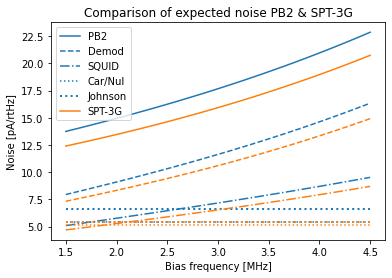

In [3]:
plt.figure()
plt.plot(f/1e6, pb_noise.total,label='PB2')
plt.plot(f/1e6, np.array(pb_noise.demod)*1e12,color=colors[0],ls='--',label='Demod')
plt.plot(f/1e6, np.array(pb_noise.csf)*pb_noise.squid.inoise*1e12,color=colors[0],ls='-.',label='SQUID')
plt.plot(f/1e6, np.ones(40)*pb_noise.warm_noise_nc*1e12,color=colors[0],ls=':',label='Car/Nul')
plt.plot(f/1e6, np.ones(40)*pb_noise.jnoise*1e12,color=colors[0],ls=':',label='Johnson',lw=2)
plt.plot(f/1e6, spt_noise.total,label='SPT-3G')
plt.plot(f/1e6, np.array(spt_noise.demod)*1e12,color=colors[1],ls='--')
plt.plot(f/1e6, np.array(spt_noise.csf)*spt_noise.squid.inoise*1e12,color=colors[1],ls='-.')
plt.plot(f/1e6, np.ones(40)*spt_noise.warm_noise_nc*1e12,color=colors[1],ls=':')
plt.plot(f/1e6, np.ones(40)*spt_noise.jnoise*1e12,color=colors[1],ls=':',lw=2)
plt.xlabel('Bias frequency [MHz]')
plt.ylabel('Noise [pA/rtHz]')
plt.legend()
plt.title('Comparison of expected noise PB2 & SPT-3G')

Demod is all the noise from the 300K electronics after the SQUID, the 1st warm amplifier, the ADC etc. 
SQUID is the noise of the SAA modulated by CS (just assuming this is 3pA/rtHz)
Car/Nul refers to the noise from the warm electronics from the carrier and nuller generation
Johnson is the johnson noise of the bolometers, and other cryogenic components. (I don't currently have the johnson noise of the bias resistor included here, this should be pretty small added in quadrature)

In [4]:
print(np.median(pb_noise.total), np.median(spt_noise.total))

17.67544135300276 15.93775875633018


This code uses a very approximate method of calculating the current sharing factor.
The only difference I know of between the two experiments is the bolometer impedance and average achieved bolometer loopgain. This should basically just impact the current sharing factor. 
This should have less of an impact than you might expect due to the impedance of the stripline (assumed 45nH)

I think this is 0th order accurate - see John's report of readout noise after fixing grounding https://bolowiki.berkeley.edu/pub/Main/JohnGroh/2019_09_20_bolo_meeting_chile_summary.pdf

A lot of what follows though depends on estimating the current sharing, and the different parasitics that go into that estimation. These numbers are probably some of the most uncertain, and the calculation of the CS should be improved. **What are the wiring harness parasitics? Are there any network analysis that can be used to estimate the CSF?**

# Stacking 2xSA13s series input, parallel output

In [5]:
sa_stacked = d.squid(700,700,3e-12,70e-9,n_series=3*64,n_parallel=2,power=80e-9,snubber=False,t=4)

#this rescales the related SAA size, same array 2x the banks in parallel
sa_stacked.scale_SAA(3*64,2*2)

pb_stacked_noise = d.dfmux_noise(sa_stacked,bolo,wh,para)
pb_stacked_noise.init_freq(f)

In [6]:
sa_stacked.print_info()

Transimpedence: 700.0 $\Omega$
Dyn. impedence: 350.0 $\Omega$
Input inductance: 140.0 nH
NEI: 2.1 pA/rtHz
Power dis.: 160.0 nW
Array size: 192x4
Linear range: 2.0 $\mu$A


Text(0.5, 1.0, 'Comparison of expected noise PB2 & Stacked SAA')

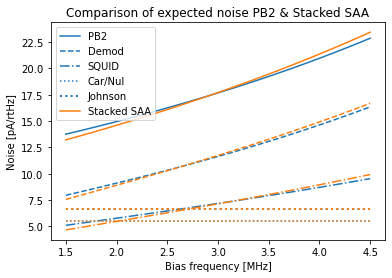

In [7]:
plt.figure()
plt.plot(f/1e6, pb_noise.total,label='PB2')
plt.plot(f/1e6, np.array(pb_noise.demod)*1e12,color=colors[0],ls='--',label='Demod')
plt.plot(f/1e6, np.array(pb_noise.csf)*pb_noise.squid.inoise*1e12,color=colors[0],ls='-.',label='SQUID')
plt.plot(f/1e6, np.ones(40)*pb_noise.warm_noise_nc*1e12,color=colors[0],ls=':',label='Car/Nul')
plt.plot(f/1e6, np.ones(40)*pb_noise.jnoise*1e12,color=colors[0],ls=':',label='Johnson',lw=2)
plt.plot(f/1e6, pb_stacked_noise.total,label='Stacked SAA')
plt.plot(f/1e6, np.array(pb_stacked_noise.demod)*1e12,color=colors[1],ls='--')
plt.plot(f/1e6, np.array(pb_stacked_noise.csf)*pb_stacked_noise.squid.inoise*1e12,color=colors[1],ls='-.')
plt.plot(f/1e6, np.ones(40)*pb_stacked_noise.warm_noise_nc*1e12,color=colors[1],ls=':')
plt.plot(f/1e6, np.ones(40)*pb_stacked_noise.jnoise*1e12,color=colors[1],ls=':',lw=2)
plt.xlabel('Bias frequency [MHz]')
plt.ylabel('Noise [pA/rtHz]')
plt.legend()
plt.title('Comparison of expected noise PB2 & Stacked SAA')

Text(0, 0.5, 'Noise enchancement factor')

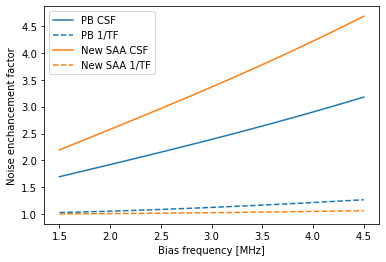

In [8]:
plt.figure()
plt.plot(f/1e6, pb_noise.csf, label='PB CSF', color=colors[0])
plt.plot(f/1e6, 1/np.array(pb_noise.tf), label='PB 1/TF', color=colors[0],ls='--')
plt.plot(f/1e6, pb_stacked_noise.csf, label='New SAA CSF', color=colors[1])
plt.plot(f/1e6, 1/np.array(pb_stacked_noise.tf), label='New SAA 1/TF', color=colors[1],ls='--')
plt.legend()
plt.xlabel('Bias frequency [MHz]')
plt.ylabel('Noise enchancement factor')

So stacking two SA13s together doesn't help much. Improves the output transfer function but mostly hurts the current sharing factor due to the input inductance of the SA13.

# Switching to STCR
Taking STCR numbers from Table 4.1 and 4.2 in Logan Howe's thesis.

Assuming that the SAA NEI is equal to $\sqrt{S_F}/M_{in}$ from Table 4.2, $250 n\Phi_0 / \sqrt{Hz} * 23.6 \mu A/\Phi_0$
If you compare this to taking the SA13 noise of ~3pA/rtHz and scaling of by $\sqrt{N_{SQ}}$ between the 64x6 SQUIDs in the SA13 to the 112 in the STCR, you get 5.5pA/rtHz. Pretty similar, this doesn't look like a crazy assumption about the noise to make. 

In [9]:
stcr = d.squid(800,600,23.6e-6*250e-9,20e-9,n_series=112,n_parallel=1,power=50e-9,snubber=False,t=4)
#stcr.scale_SAA(3*64,2*2)
wh.rshunt = False
pb_stcr_noise = d.dfmux_noise(stcr,bolo,wh,para)
pb_stcr_noise.init_freq(f)

Text(0.5, 1.0, 'Comparison of expected noise PB2')

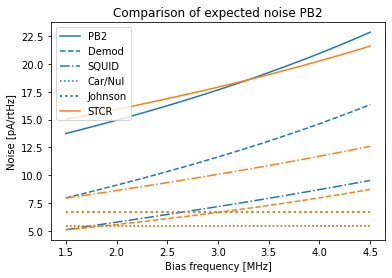

In [10]:
plt.figure()
plt.plot(f/1e6, pb_noise.total,label='PB2')
plt.plot(f/1e6, np.array(pb_noise.demod)*1e12,color=colors[0],ls='--',label='Demod')
plt.plot(f/1e6, np.array(pb_noise.csf)*pb_noise.squid.inoise*1e12,color=colors[0],ls='-.',label='SQUID')
plt.plot(f/1e6, np.ones(40)*pb_noise.warm_noise_nc*1e12,color=colors[0],ls=':',label='Car/Nul')
plt.plot(f/1e6, np.ones(40)*pb_noise.jnoise*1e12,color=colors[0],ls=':',label='Johnson',lw=2)
plt.plot(f/1e6, pb_stcr_noise.total,label='STCR')
plt.plot(f/1e6, np.array(pb_stcr_noise.demod)*1e12,color=colors[1],ls='--')
plt.plot(f/1e6, np.array(pb_stcr_noise.csf)*pb_stcr_noise.squid.inoise*1e12,color=colors[1],ls='-.')
plt.plot(f/1e6, np.ones(40)*pb_stcr_noise.warm_noise_nc*1e12,color=colors[1],ls=':')
plt.plot(f/1e6, np.ones(40)*pb_stcr_noise.jnoise*1e12,color=colors[1],ls=':',lw=2)
plt.xlabel('Bias frequency [MHz]')
plt.ylabel('Noise [pA/rtHz]')
plt.legend()
plt.title('Comparison of expected noise PB2')

So this isn't going to help much. 

# Stacked STCR
What about doing the same stacking but with a STCR? SQ noise reduces like $\sqrt{N_{sq}}$ right?

In [11]:
stacked_stcr = d.squid(800,600,23.6e-6*250e-9,20e-9,n_series=112,n_parallel=1,power=50e-9,snubber=False,t=4)
stacked_stcr.scale_SAA(112,2)

pb_stacked_stcr_noise = d.dfmux_noise(stacked_stcr,bolo,wh,para)
pb_stacked_stcr_noise.init_freq(f)

In [12]:
stacked_stcr.print_info()

Transimpedence: 800.0 $\Omega$
Dyn. impedence: 300.0 $\Omega$
Input inductance: 40.0 nH
NEI: 4.2 pA/rtHz
Power dis.: 100.0 nW
Array size: 112x2
Linear range: 2.0 $\mu$A


Text(0.5, 1.0, 'Comparison of expected noise PB2')

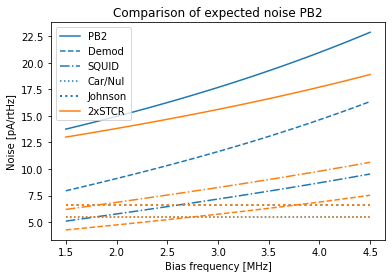

In [13]:
plt.figure()
plt.plot(f/1e6, pb_noise.total,label='PB2')
plt.plot(f/1e6, np.array(pb_noise.demod)*1e12,color=colors[0],ls='--',label='Demod')
plt.plot(f/1e6, np.array(pb_noise.csf)*pb_noise.squid.inoise*1e12,color=colors[0],ls='-.',label='SQUID')
plt.plot(f/1e6, np.ones(40)*pb_noise.warm_noise_nc*1e12,color=colors[0],ls=':',label='Car/Nul')
plt.plot(f/1e6, np.ones(40)*pb_noise.jnoise*1e12,color=colors[0],ls=':',label='Johnson',lw=2)
plt.plot(f/1e6, pb_stacked_stcr_noise.total,label='{}xSTCR'.format(stacked_stcr.n_parallel))
plt.plot(f/1e6, np.array(pb_stacked_stcr_noise.demod)*1e12,color=colors[1],ls='--')
plt.plot(f/1e6, np.array(pb_stacked_stcr_noise.csf)*pb_stacked_stcr_noise.squid.inoise*1e12,color=colors[1],ls='-.')
plt.plot(f/1e6, np.ones(40)*pb_stacked_stcr_noise.warm_noise_nc*1e12,color=colors[1],ls=':')
plt.plot(f/1e6, np.ones(40)*pb_stacked_stcr_noise.jnoise*1e12,color=colors[1],ls=':',lw=2)
plt.xlabel('Bias frequency [MHz]')
plt.ylabel('Noise [pA/rtHz]')
plt.legend()
plt.title('Comparison of expected noise PB2')



# Changing R48
This can mess up the SAA if things are not done properly - exposing the SAA to junk which will degrade the transimpedence ect. 
100 $\Omega$ has been fine previously, but would need to test this.
This is also assuming that PB has the same parasitic capacitance to ground as SPT-3G. Ballpark reasonable but that's a big ballpark.

In [14]:
para_r48 = d.parasitics(45e-9,0.7e-9,100)
pb_r48_noise = d.dfmux_noise(sa13,bolo,wh,para_r48)
pb_r48_noise.init_freq(f)

Text(0.5, 1.0, 'Comparison of expected noise')

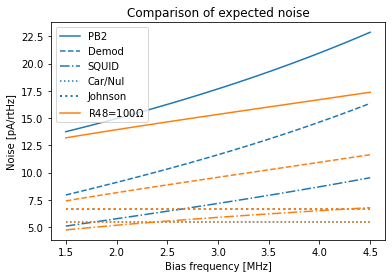

In [15]:
plt.figure()
plt.plot(f/1e6, pb_noise.total,label='PB2')
plt.plot(f/1e6, np.array(pb_noise.demod)*1e12,color=colors[0],ls='--',label='Demod')
plt.plot(f/1e6, np.array(pb_noise.csf)*pb_noise.squid.inoise*1e12,color=colors[0],ls='-.',label='SQUID')
plt.plot(f/1e6, np.ones(40)*pb_noise.warm_noise_nc*1e12,color=colors[0],ls=':',label='Car/Nul')
plt.plot(f/1e6, np.ones(40)*pb_noise.jnoise*1e12,color=colors[0],ls=':',label='Johnson',lw=2)
plt.plot(f/1e6, pb_r48_noise.total,label='R48=100$\Omega$')
plt.plot(f/1e6, np.array(pb_r48_noise.demod)*1e12,color=colors[1],ls='--')
plt.plot(f/1e6, np.array(pb_r48_noise.csf)*pb_r48_noise.squid.inoise*1e12,color=colors[1],ls='-.')
plt.plot(f/1e6, np.ones(40)*pb_r48_noise.warm_noise_nc*1e12,color=colors[1],ls=':')
plt.plot(f/1e6, np.ones(40)*pb_r48_noise.jnoise*1e12,color=colors[1],ls=':',lw=2)
plt.xlabel('Bias frequency [MHz]')
plt.ylabel('Noise [pA/rtHz]')
plt.legend()
plt.title('Comparison of expected noise')

So assuming that 
1) The parasitic capacitance to ground is similar to that in SPT-3G 
2) That ~100 $\Omega$ of resistance can be put in R48 without disturbing SAA performance
PB2 could see some noise gains with SA13s.

# R48 with STCRs

In [16]:
pb_stcr_r48_noise = d.dfmux_noise(stacked_stcr,bolo,wh,para_r48)
pb_stcr_r48_noise.init_freq(f)

Text(0.5, 1.0, 'Comparison of expected noise')

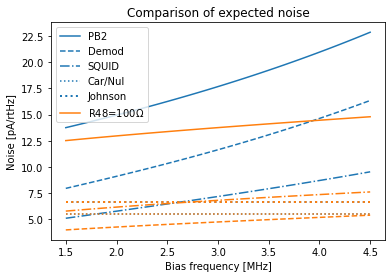

In [17]:
plt.figure()
plt.plot(f/1e6, pb_noise.total,label='PB2')
plt.plot(f/1e6, np.array(pb_noise.demod)*1e12,color=colors[0],ls='--',label='Demod')
plt.plot(f/1e6, np.array(pb_noise.csf)*pb_noise.squid.inoise*1e12,color=colors[0],ls='-.',label='SQUID')
plt.plot(f/1e6, np.ones(40)*pb_noise.warm_noise_nc*1e12,color=colors[0],ls=':',label='Car/Nul')
plt.plot(f/1e6, np.ones(40)*pb_noise.jnoise*1e12,color=colors[0],ls=':',label='Johnson',lw=2)
plt.plot(f/1e6, pb_stcr_r48_noise.total,label='R48=100$\Omega$')
plt.plot(f/1e6, np.array(pb_stcr_r48_noise.demod)*1e12,color=colors[1],ls='--')
plt.plot(f/1e6, np.array(pb_stcr_r48_noise.csf)*pb_stcr_r48_noise.squid.inoise*1e12,color=colors[1],ls='-.')
plt.plot(f/1e6, np.ones(40)*pb_stcr_r48_noise.warm_noise_nc*1e12,color=colors[1],ls=':')
plt.plot(f/1e6, np.ones(40)*pb_stcr_r48_noise.jnoise*1e12,color=colors[1],ls=':',lw=2)
plt.xlabel('Bias frequency [MHz]')
plt.ylabel('Noise [pA/rtHz]')
plt.legend()
plt.title('Comparison of expected noise')

# To Do:

Treat CS more accurately - calculate with PySpice instead 

Add in johnson noise from bias resistor. 